# Exploratory Data Analysis

In [5]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller

## Load Data from Pickle

In [6]:
with open('../resources/1_dataframes.pkl', 'rb') as f:
    dataframes = pickle.load(f)

In [7]:
df_train = dataframes['df_train']
df_filtered = dataframes['df_filtered']
df_holiday_events = dataframes['df_holiday_events']
df_items = dataframes['df_items']
df_oil = dataframes['df_oil']
df_stores = dataframes['df_stores']
df_transactions = dataframes['df_transactions']

In [8]:
df_filtered

,unit_sales
date,
2013-01-02,42320.000
2013-01-03,32708.000
2013-01-04,30847.000
2013-01-05,42351.000
2013-01-06,43988.000
...,...
2017-08-11,80783.227
2017-08-12,77928.860
2017-08-13,92090.859


## Step 1 - Checking for Missing Data

### df_train

In [9]:
df_train.isnull().sum()

id                   0
date                 0
store_nbr            0
item_nbr             0
unit_sales           0
onpromotion    2747275
dtype: int64

Promotions are rare and `NaN` values should be `False`.

In [10]:
df_train['onpromotion'] = df_train['onpromotion'].fillna(0).astype(bool)

In [11]:
df_train.isnull().sum()

id             0
date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
dtype: int64

### df_holiday_events

In [12]:
df_holiday_events.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

### df_items

In [13]:
df_items.isnull().sum()

item_nbr      0
family        0
class         0
perishable    0
dtype: int64

### df_oil

In [14]:
df_oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

We drop unavailable data points:

In [15]:
df_oil.dropna(axis=0, inplace=True)

In [16]:
df_oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

### df_stores

In [17]:
df_stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

### df_transactions

In [18]:
df_transactions.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

### df_filtered

In [19]:
df_filtered.isnull().sum()

unit_sales    0
dtype: int64

## Step 2 - Handling Outliers

### Negative Product Returns

In [20]:
df_train[df_train['unit_sales'] < 0]

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
18589,106658,2013-01-04,34,586824,-2.0,False
54236,309805,2013-01-09,35,1079215,-8.0,False
64452,382905,2013-01-11,27,1097187,-20.0,False
96414,564108,2013-01-15,51,627885,-36.0,False
132903,787522,2013-01-21,24,211205,-5.0,False
...,...,...,...,...,...,...
22823662,124830870,2017-08-09,32,258395,-2.0,False
22830152,124870543,2017-08-09,51,1354711,-3.0,False
22830326,124870717,2017-08-09,51,1463602,-2.0,False
22887719,125230016,2017-08-13,24,2010786,-1.0,False


In [21]:
# Replace negative sales with 0 to reflect returns as non-sales
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

In [22]:
df_train[df_train['unit_sales'] < 0]

,id,date,store_nbr,item_nbr,unit_sales,onpromotion


In [23]:
df_filtered[df_filtered['unit_sales'] < 0]

,unit_sales
date,


### Extremely High Sales

We can calculate the Z-score to determine how many standard deviations away from the mean a value is.

In [24]:
def calc_store_item_zscore(series):
    mean_sales = series.mean()
    std_sales = series.std()
    return (series - mean_sales) / (std_sales if std_sales != 0 else 1)

df_train['z-score'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(calc_store_item_zscore)

# Threshold for outliers: z-score > 5
outliers = df_train[df_train['z-score'] > 5]

print(f"Number of outliers detected: {len(outliers)}")
outliers

Number of outliers detected: 48485


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z-score
32,18821,2013-01-02,24,119026,80.0,False,5.289391
80,18869,2013-01-02,24,168989,63.0,False,9.294021
155,18944,2013-01-02,24,260893,61.0,False,5.211604
522,19311,2013-01-02,24,637016,14.0,False,5.436600
1041,20644,2013-01-02,26,115850,20.0,False,6.768451
...,...,...,...,...,...,...,...
22937933,125456228,2017-08-15,36,518091,306.0,True,9.187648
22939218,125457513,2017-08-15,36,1999775,13.0,False,5.865977
22939298,125457593,2017-08-15,36,2016407,28.0,True,6.895180
22939548,125489417,2017-08-15,51,213788,25.0,False,8.412644


We're not acting on these outliers now, so let's delete the z-score column.

In [25]:
df_train.drop(columns=['z-score'], inplace=True)
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
1,18790,2013-01-02,24,105574,12.0,False
2,18791,2013-01-02,24,105575,2.0,False
3,18792,2013-01-02,24,105577,1.0,False
4,18793,2013-01-02,24,105693,7.0,False
5,18794,2013-01-02,24,105737,17.0,False


## Step 3 - Filling Missing Dates with Zero Sales

Time-series models expect a complete calendar.

Turn the `date` column into a datetime.

In [26]:
df_train['date'] = pd.to_datetime(df_train['date'])

In [27]:
# Create a full daily calendar for every store-item pair
def fill_calendar(group):
    g = group.set_index('date').sort_index()

    # fill daily, add 0 if missing
    date_range = pd.date_range(start=g.index.min(), end=g.index.max(), freq='D')
    g = g.reindex(date_range, fill_value=0).reset_index()
    g.rename(columns={g.columns[0]: 'date'}, inplace=True)

    # restore identifiers
    g['store_nbr'] = group['store_nbr'].iloc[0]
    g['item_nbr'] = group['item_nbr'].iloc[0]

    return g

In [28]:
import warnings

# Temporarily suppress the specific FutureWarning about apply
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    df_train = df_train.groupby(['store_nbr', 'item_nbr'], group_keys=False).apply(fill_calendar)

df_train

,date,id,store_nbr,item_nbr,unit_sales,onpromotion
0,2013-01-09,302230,24,96995,2.0,False
1,2013-01-10,0,24,96995,0.0,0
2,2013-01-11,0,24,96995,0.0,0
3,2013-01-12,419989,24,96995,2.0,False
4,2013-01-13,0,24,96995,0.0,0
...,...,...,...,...,...,...
16,2017-08-02,0,51,2127114,0.0,0
17,2017-08-03,0,51,2127114,0.0,0
18,2017-08-04,0,51,2127114,0.0,0
19,2017-08-05,0,51,2127114,0.0,0


## Step 4 - Feature Engineering

### year, month, day, day_of_week

In [29]:
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek

df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week
0,2013-01-09,302230,24,96995,2.0,False,2013,1,9,2
1,2013-01-10,0,24,96995,0.0,0,2013,1,10,3
2,2013-01-11,0,24,96995,0.0,0,2013,1,11,4
3,2013-01-12,419989,24,96995,2.0,False,2013,1,12,5
4,2013-01-13,0,24,96995,0.0,0,2013,1,13,6


### Rolling (moving) averages

7-day rolling average of unit_sales per (item, store)

In [33]:
df_train = df_train.sort_values(["item_nbr", "store_nbr", "date"]).reset_index(drop=True)

df_train["rolling_mean_7d"] = (
    df_train
    .groupby(["item_nbr", "store_nbr"])["unit_sales"]
    .transform(lambda s: s.rolling(window=7, min_periods=1).mean())
)

df_train

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,rolling_mean_7d
0,2013-01-09,302230,24,96995,2.0,False,2013,1,9,2,2.000000
1,2013-01-10,0,24,96995,0.0,0,2013,1,10,3,1.000000
2,2013-01-11,0,24,96995,0.0,0,2013,1,11,4,0.666667
3,2013-01-12,419989,24,96995,2.0,False,2013,1,12,5,1.000000
4,2013-01-13,0,24,96995,0.0,0,2013,1,13,6,0.800000
...,...,...,...,...,...,...,...,...,...,...,...
23403655,2017-08-02,0,51,2127114,0.0,0,2017,8,2,2,1.000000
23403656,2017-08-03,0,51,2127114,0.0,0,2017,8,3,3,1.000000
23403657,2017-08-04,0,51,2127114,0.0,0,2017,8,4,4,0.857143
23403658,2017-08-05,0,51,2127114,0.0,0,2017,8,5,5,0.857143


14-day rolling average of unit_sales per (item, store)

In [34]:
df_train["rolling_mean_14d"] = (
    df_train
    .groupby(["item_nbr", "store_nbr"])["unit_sales"]
    .transform(lambda s: s.rolling(window=14, min_periods=1).mean())
)

df_train

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,rolling_mean_7d,rolling_mean_14d
0,2013-01-09,302230,24,96995,2.0,False,2013,1,9,2,2.000000,2.000000
1,2013-01-10,0,24,96995,0.0,0,2013,1,10,3,1.000000,1.000000
2,2013-01-11,0,24,96995,0.0,0,2013,1,11,4,0.666667,0.666667
3,2013-01-12,419989,24,96995,2.0,False,2013,1,12,5,1.000000,1.000000
4,2013-01-13,0,24,96995,0.0,0,2013,1,13,6,0.800000,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...
23403655,2017-08-02,0,51,2127114,0.0,0,2017,8,2,2,1.000000,1.000000
23403656,2017-08-03,0,51,2127114,0.0,0,2017,8,3,3,1.000000,1.000000
23403657,2017-08-04,0,51,2127114,0.0,0,2017,8,4,4,0.857143,1.000000
23403658,2017-08-05,0,51,2127114,0.0,0,2017,8,5,5,0.857143,1.000000


Lags for 1 day, 7 days and 30 days.

In [35]:
df_train["lag_1d"] = (
    df_train
    .groupby(["item_nbr", "store_nbr"])["unit_sales"]
    .transform(lambda s: s.shift(1))
)

df_train["lag_7d"] = (
    df_train
    .groupby(["item_nbr", "store_nbr"])["unit_sales"]
    .transform(lambda s: s.shift(7))
)

df_train["lag_30d"] = (
    df_train
    .groupby(["item_nbr", "store_nbr"])["unit_sales"]
    .transform(lambda s: s.shift(30))
)

df_train

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,rolling_mean_7d,rolling_mean_14d,lag_1d,lag_7d,lag_30d
0,2013-01-09,302230,24,96995,2.0,False,2013,1,9,2,2.000000,2.000000,NaN,NaN,NaN
1,2013-01-10,0,24,96995,0.0,0,2013,1,10,3,1.000000,1.000000,2.0,NaN,NaN
2,2013-01-11,0,24,96995,0.0,0,2013,1,11,4,0.666667,0.666667,0.0,NaN,NaN
3,2013-01-12,419989,24,96995,2.0,False,2013,1,12,5,1.000000,1.000000,0.0,NaN,NaN
4,2013-01-13,0,24,96995,0.0,0,2013,1,13,6,0.800000,0.800000,2.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23403655,2017-08-02,0,51,2127114,0.0,0,2017,8,2,2,1.000000,1.000000,5.0,0.0,NaN
23403656,2017-08-03,0,51,2127114,0.0,0,2017,8,3,3,1.000000,1.000000,0.0,0.0,NaN
23403657,2017-08-04,0,51,2127114,0.0,0,2017,8,4,4,0.857143,1.000000,0.0,1.0,NaN
23403658,2017-08-05,0,51,2127114,0.0,0,2017,8,5,5,0.857143,1.000000,0.0,0.0,NaN


In [30]:
df_filtered['lag_1'] = df_filtered['unit_sales'].shift(1)
df_filtered['lag_7'] = df_filtered['unit_sales'].shift(7)
df_filtered['lag_30'] = df_filtered['unit_sales'].shift(30)

In [31]:
df_filtered.dropna(inplace=True)

In [32]:
df_filtered

,unit_sales,lag_1,lag_7,lag_30
date,,,,
2013-02-01,36573.000,28617.000,30331.000,42320.000
2013-02-02,48688.000,36573.000,37642.000,32708.000
2013-02-03,46210.000,48688.000,38829.000,30847.000
2013-02-04,31774.000,46210.000,28117.000,42351.000
2013-02-05,30152.000,31774.000,26737.000,43988.000
...,...,...,...,...
2017-08-11,80783.227,58967.992,71155.344,62441.805
2017-08-12,77928.860,80783.227,89231.789,55686.171
2017-08-13,92090.859,77928.860,106027.906,65251.711


### For df_filtered

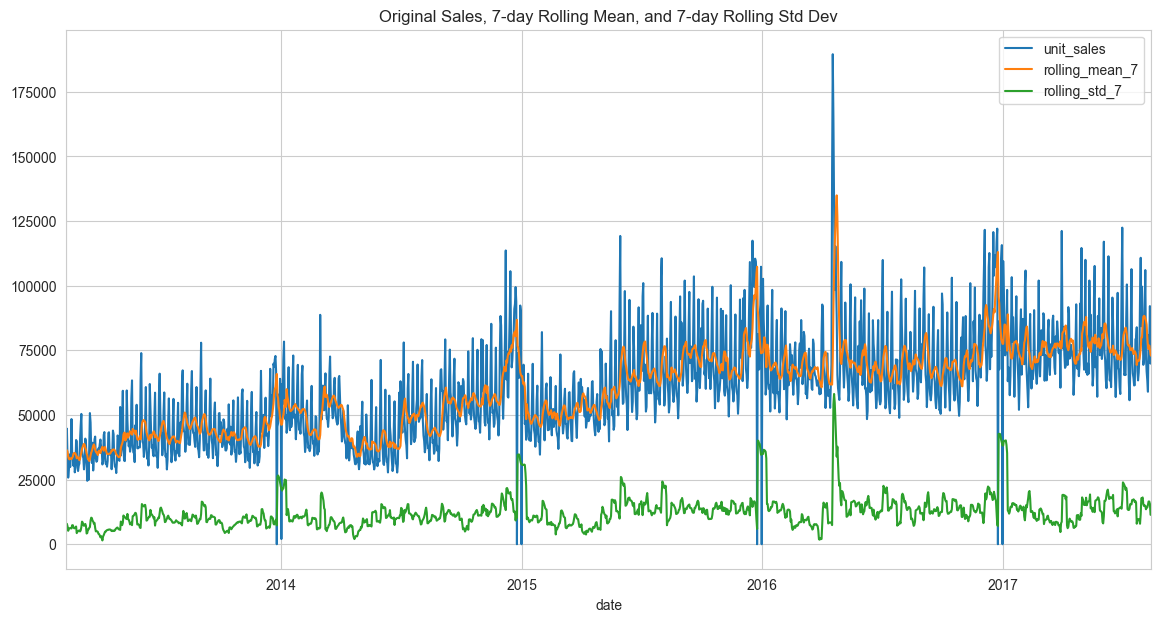

In [36]:
df_filtered['rolling_mean_7'] = df_filtered['unit_sales'].shift(1).rolling(window=7).mean()
df_filtered['rolling_std_7'] = df_filtered['unit_sales'].shift(1).rolling(window=7).std()

# Drop any NaN values after creating rolling features
df_filtered.dropna(inplace=True)

# Visualize the new features alongside the original sales
df_filtered[['unit_sales', 'rolling_mean_7', 'rolling_std_7']].plot(figsize=(14, 7))
plt.title('Original Sales, 7-day Rolling Mean, and 7-day Rolling Std Dev')
plt.show()

## Save Cleaned Data

In [37]:
df_train.to_csv('../resources/guayas_prepared.csv', index=False)

In [38]:
dataframes = {
    'df_holiday_events': df_holiday_events,
    'df_items': df_items,
    'df_oil': df_oil,
    'df_stores': df_stores,
    'df_transactions': df_transactions,
    'df_train': df_train,
    'df_filtered': df_filtered,
}

with open('../resources/2_dataframes.pkl', 'wb') as f:
    pickle.dump(dataframes, f)

## Step 5 - Visualizing Time-Series Data

### Sales Over Time

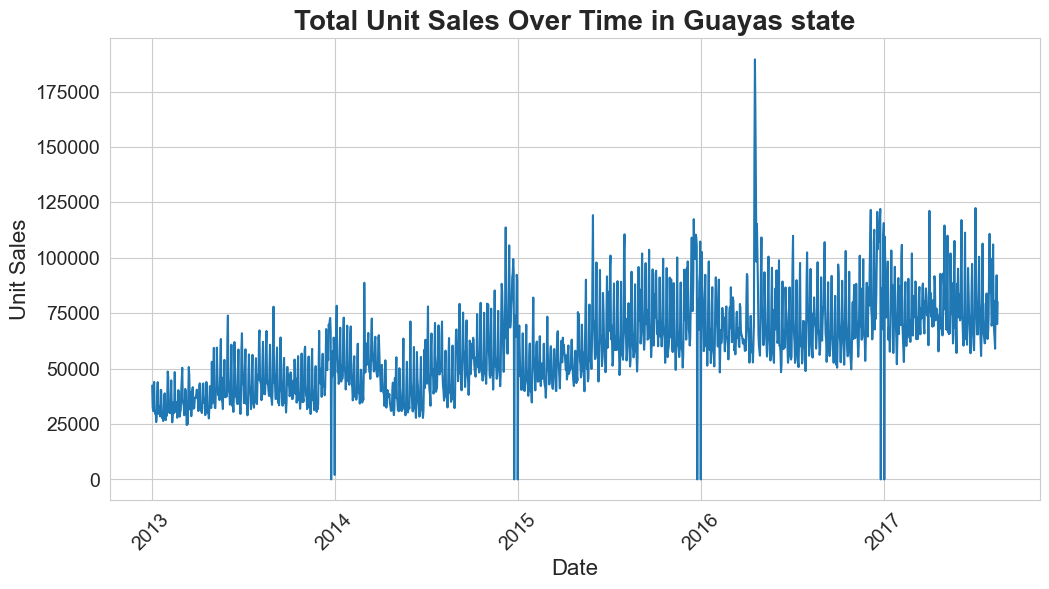

In [39]:
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

#### Analysis

* **Overall Growth Trend**
    * There is a general upward trend in sales over time.
    * In 2013 most saled fluctuate between 2000 and 8000 units per day
    * From 2016-2017 peak sales exceeded between 10,000 and over 15,000 units per day
* **Recurring Sharp Dips**
    * Once a year there are sharp drops close to zero
        * These are likeliy non-operating days: Christmas, New Years,...
    * Because these drops are consistent, these events should be factored into forecasting to avoid skewed predictions
* **Seasonality**
    * We can see a slight drop in sales at the beginning of each year and an increase in sales towards the end of each year.
    * The second half of each year has higher sales

### Sales Trend by Year and Month

In [40]:
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

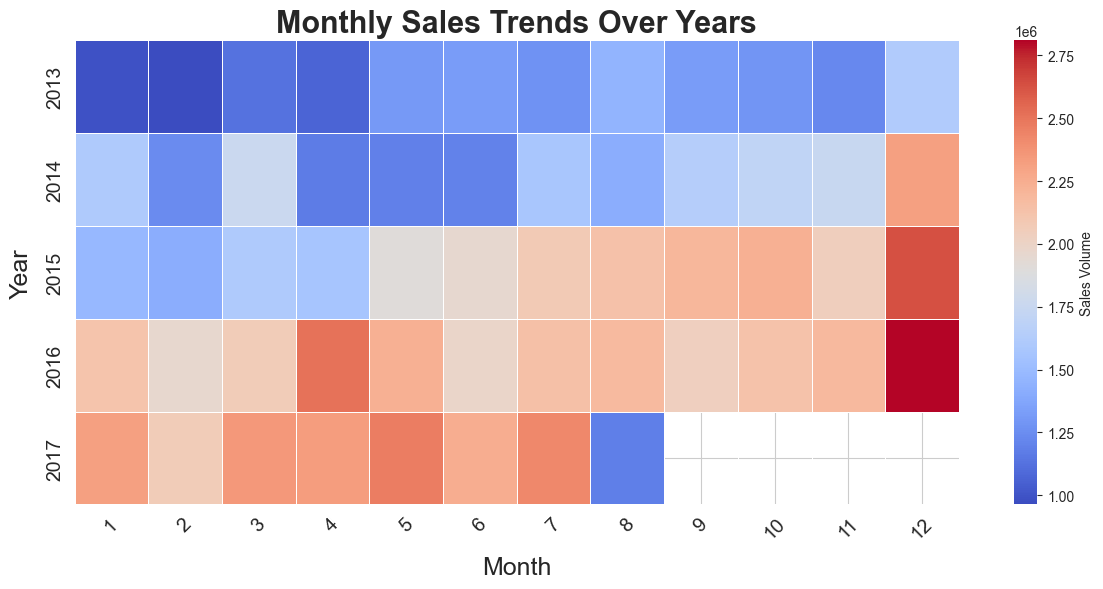

In [41]:
plt.figure(figsize=(12,6))
sns.heatmap(
    sales_by_month,
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Sales Volume'}
)

plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)
plt.ylabel('Year', fontsize=18, labelpad=10)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

#### Analysis

* **Seasonal Patterns**
    * Similarily to the total sales plot, we can see an increase in sales over the year with December being the top sales month every year.
    * The first few months each year show lower sales, which is common in retail (after the holiday season)
* **YoY Growth**
    * We can clearly see an upwards trend over the years (blue to red)
* **August 2017**
    * We can see an unexpected drop in August 2017, which is probably caused by incomplete data for that month

## Step 6 - Examining the Impact of Holidays on Sales

From the holiday events data, we can see how holidays may affect sales.

In [42]:
df_holiday_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [43]:
# Convert date column to datetime
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])
print(
    "Holiday file covers:",
    df_holiday_events['date'].dt.date.min(), "→",
    df_holiday_events['date'].dt.date.max()
)

Holiday file covers: 2012-03-02 → 2017-12-26


Let's join the holidays with our sales data

In [44]:
df_train_holiday = pd.merge(
    df_train,
    df_holiday_events[['date', 'type']],
    on='date',
    how='left',
)
df_train_holiday.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,rolling_mean_7d,rolling_mean_14d,lag_1d,lag_7d,lag_30d,type
0,2013-01-09,302230,24,96995,2.0,False,2013,1,9,2,2.000000,2.000000,NaN,NaN,NaN,NaN
1,2013-01-10,0,24,96995,0.0,0,2013,1,10,3,1.000000,1.000000,2.0,NaN,NaN,NaN
2,2013-01-11,0,24,96995,0.0,0,2013,1,11,4,0.666667,0.666667,0.0,NaN,NaN,NaN
3,2013-01-12,419989,24,96995,2.0,False,2013,1,12,5,1.000000,1.000000,0.0,NaN,NaN,Work Day
4,2013-01-13,0,24,96995,0.0,0,2013,1,13,6,0.800000,0.800000,2.0,NaN,NaN,NaN


Compare average sales for each holiday type

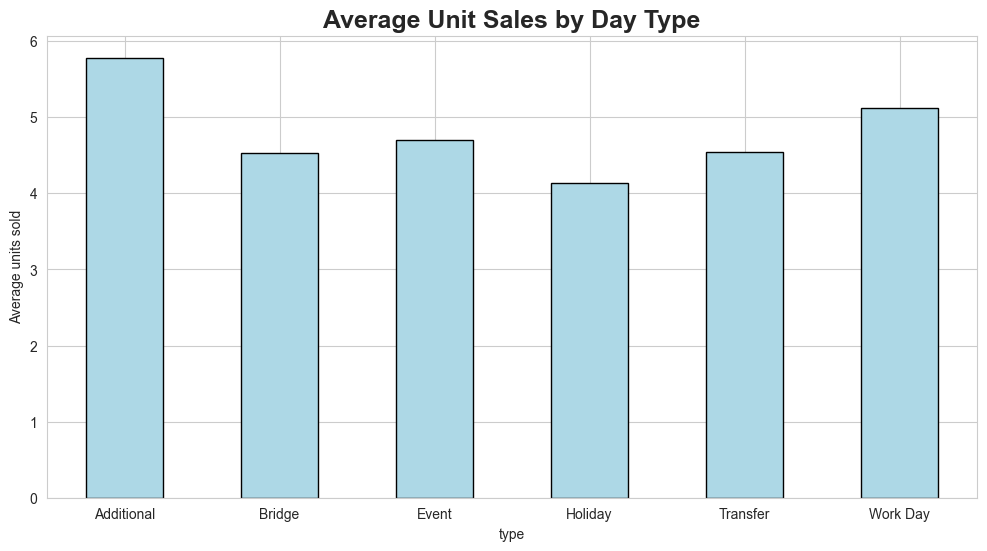

In [45]:
holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()

holiday_sales.plot(kind='bar', figsize=(12, 6), color='lightblue', edgecolor='black')
plt.title('Average Unit Sales by Day Type', fontsize=18, weight='bold')
plt.ylabel('Average units sold')
plt.xticks(rotation=0)
plt.show()

* Highest sales on work days and additional holidays
* Lowest sales on public holidays

## Step 7 - Analyzing Perishable Items

In [46]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


Let's merge item data with our train data, so we know which items were sold

In [47]:
df_train_items = pd.merge(df_train, df_items, on='item_nbr', how='left')
df_train_items['perishable'] = df_train_items['perishable'].astype(bool)
df_train_items.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,rolling_mean_7d,rolling_mean_14d,lag_1d,lag_7d,lag_30d,family,class,perishable
0,2013-01-09,302230,24,96995,2.0,False,2013,1,9,2,2.000000,2.000000,NaN,NaN,NaN,GROCERY I,1093,False
1,2013-01-10,0,24,96995,0.0,0,2013,1,10,3,1.000000,1.000000,2.0,NaN,NaN,GROCERY I,1093,False
2,2013-01-11,0,24,96995,0.0,0,2013,1,11,4,0.666667,0.666667,0.0,NaN,NaN,GROCERY I,1093,False
3,2013-01-12,419989,24,96995,2.0,False,2013,1,12,5,1.000000,1.000000,0.0,NaN,NaN,GROCERY I,1093,False
4,2013-01-13,0,24,96995,0.0,0,2013,1,13,6,0.800000,0.800000,2.0,NaN,NaN,GROCERY I,1093,False


Comparing total sales for perishable vs. non-perishable items

In [48]:
df_train_items['perishable'].value_counts()

perishable
False    23403660
Name: count, dtype: int64

Apparently there are no perishable items in the dataset for the Guayas state.

## Step 8 - Analyzing the Impact of Oil Prices

In [49]:
df_oil

,date,dcoilwtico
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [50]:
df_oil['date'] = pd.to_datetime(df_oil['date'])

In [51]:
# aggregate to daily sales to reduce memory usage
daily_sales = df_train.groupby('date')['unit_sales'].sum().reset_index()

df_daily_oil_sales = pd.merge(daily_sales, df_oil, on='date', how='left')

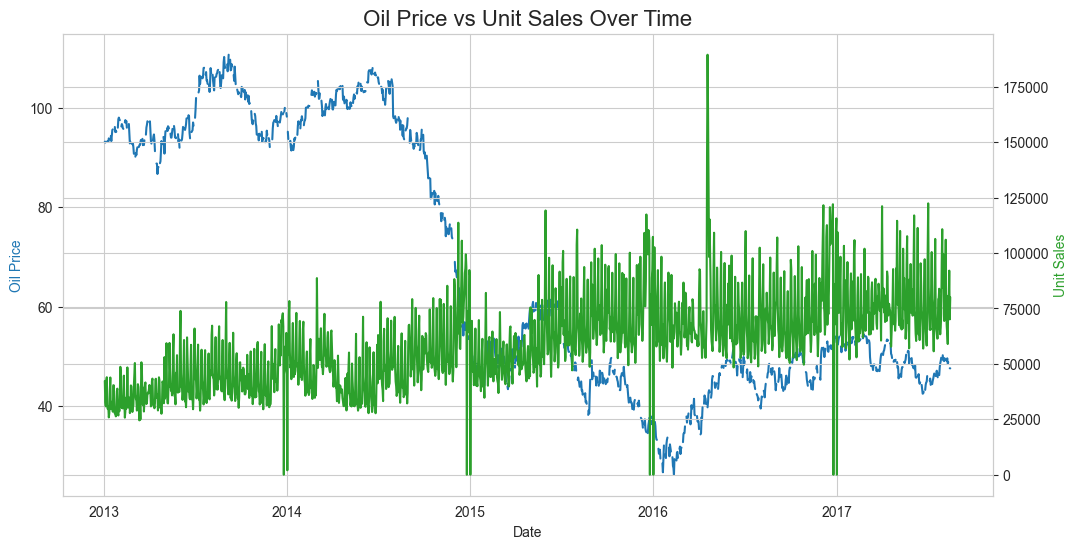

In [52]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Oil Price', color='tab:blue')
ax1.plot(df_daily_oil_sales['date'], df_daily_oil_sales['dcoilwtico'], color='tab:blue', label='Oil Price')
ax2 = ax1.twinx()
ax2.set_ylabel('Unit Sales', color='tab:green')
ax2.plot(df_daily_oil_sales['date'], df_daily_oil_sales['unit_sales'], color='tab:green', label='Unit Sales')

plt.title('Oil Price vs Unit Sales Over Time', fontsize=16)
plt.show()

**Analysis**

* **Trends Long-term**
    * Oil prices crashed from mid-2014 to 2016 from +$100 to below $50
    * Daily unit sales steadily increased from around 2500 to over 10,000 units per day
    * **Conclusion**: Oil prices have no obvious impact on sales
* **Trends Short-term**
    * Daily unit sales do not seem to coincide with oil price fluctuations

#### Zoomed time-slice

Maybe we can spot some patterns when zooming in?

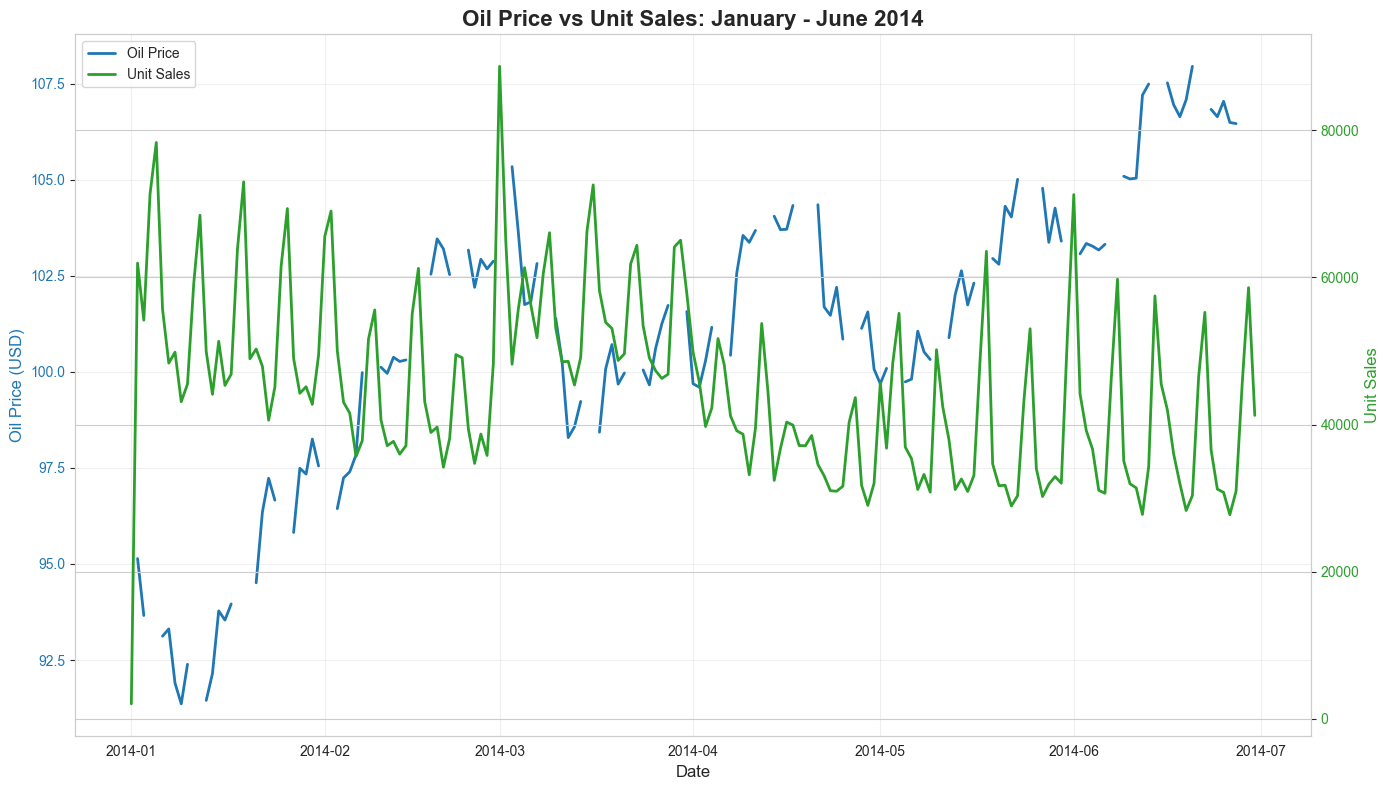

Correlation coefficient (Jan-Jun 2014): -0.567


In [53]:
# Filter data for several 3-6 month windows
start_date = '2014-01-01'
end_date = '2014-06-30'

df_2014_h1 = df_daily_oil_sales[
    (df_daily_oil_sales['date'] >= start_date) &
    (df_daily_oil_sales['date'] <= end_date)
].copy()

fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Oil Price (USD)', color='tab:blue', fontsize=12)
line1 = ax1.plot(df_2014_h1['date'], df_2014_h1['dcoilwtico'],
                 color='tab:blue', linewidth=2, label='Oil Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('Unit Sales', color='tab:green', fontsize=12)
line2 = ax2.plot(df_2014_h1['date'], df_2014_h1['unit_sales'],
                 color='tab:green', linewidth=2, label='Unit Sales')
ax2.tick_params(axis='y', labelcolor='tab:green')


lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title('Oil Price vs Unit Sales: January - June 2014', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


correlation = df_2014_h1[['dcoilwtico', 'unit_sales']].corr().iloc[0,1]
print(f"Correlation coefficient (Jan-Jun 2014): {correlation:.3f}")

**Analysis**

* Depending on the time-slice, the correlation between oil price and unit sales is either negative or positive, leading to no clear pattern
* The impact of the oil price seems to have an impact before the oil price crashes with negative correlations, suggesting that consumers spend less when oil prices are high
* After the crash the correlation is sometimes positive or near 0

**Conslusion**: A high oil price might affect consumer behavior, but there is no clear evidence that oil prices have an impact on sales

#### Rolling correlation

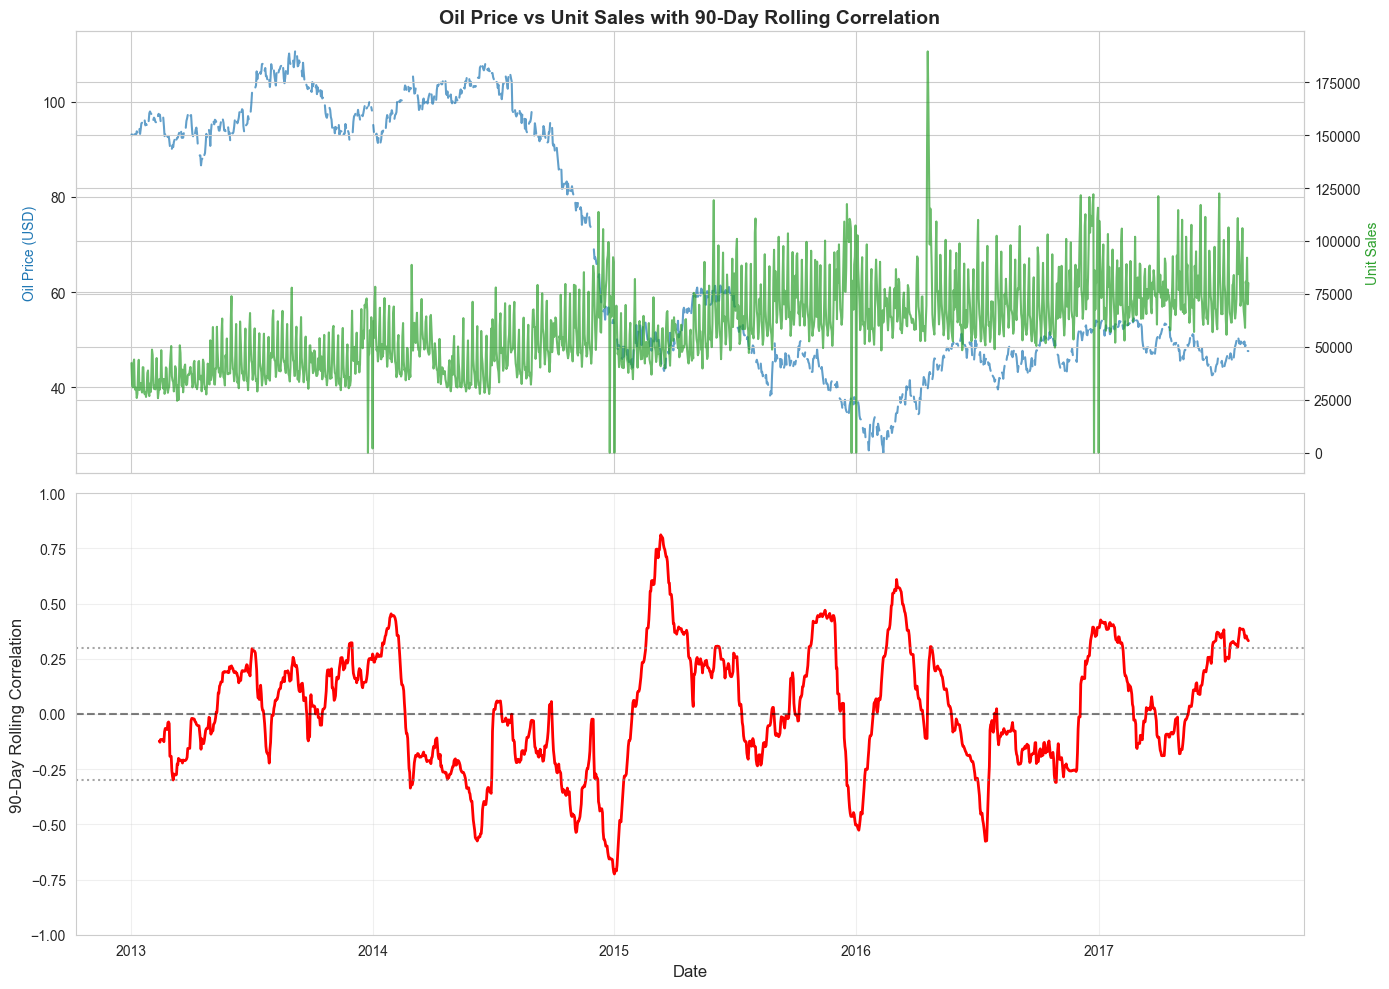

Periods of strong positive correlation (>0.3): 278 days
Periods of strong negative correlation (<-0.3): 167 days
Overall correlation range: -0.725 to 0.812


In [54]:
df_daily_oil_sales = df_daily_oil_sales.sort_values('date').reset_index(drop=True)

# Rolling correlation with 90-day window
rolling_corr = df_daily_oil_sales['dcoilwtico'].rolling(window=90, min_periods=30).corr(
    df_daily_oil_sales['unit_sales']
)

# Oil prices and sales
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax1.plot(df_daily_oil_sales['date'], df_daily_oil_sales['dcoilwtico'],
         color='tab:blue', alpha=0.7, label='Oil Price')
ax1_twin = ax1.twinx()
ax1_twin.plot(df_daily_oil_sales['date'], df_daily_oil_sales['unit_sales'],
              color='tab:green', alpha=0.7, label='Unit Sales')

ax1.set_ylabel('Oil Price (USD)', color='tab:blue')
ax1_twin.set_ylabel('Unit Sales', color='tab:green')
ax1.set_title('Oil Price vs Unit Sales with 90-Day Rolling Correlation', fontsize=14, fontweight='bold')

# Rolling correlation
ax2.plot(df_daily_oil_sales['date'], rolling_corr, color='red', linewidth=2)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.axhline(y=0.3, color='gray', linestyle=':', alpha=0.7, label='Moderate correlation threshold')
ax2.axhline(y=-0.3, color='gray', linestyle=':', alpha=0.7)

ax2.set_ylabel('90-Day Rolling Correlation', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylim(-1, 1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

strong_positive = rolling_corr[rolling_corr > 0.3]
strong_negative = rolling_corr[rolling_corr < -0.3]

print(f"Periods of strong positive correlation (>0.3): {len(strong_positive)} days")
print(f"Periods of strong negative correlation (<-0.3): {len(strong_negative)} days")
print(f"Overall correlation range: {rolling_corr.min():.3f} to {rolling_corr.max():.3f}")

#### Year-by-Year correlation

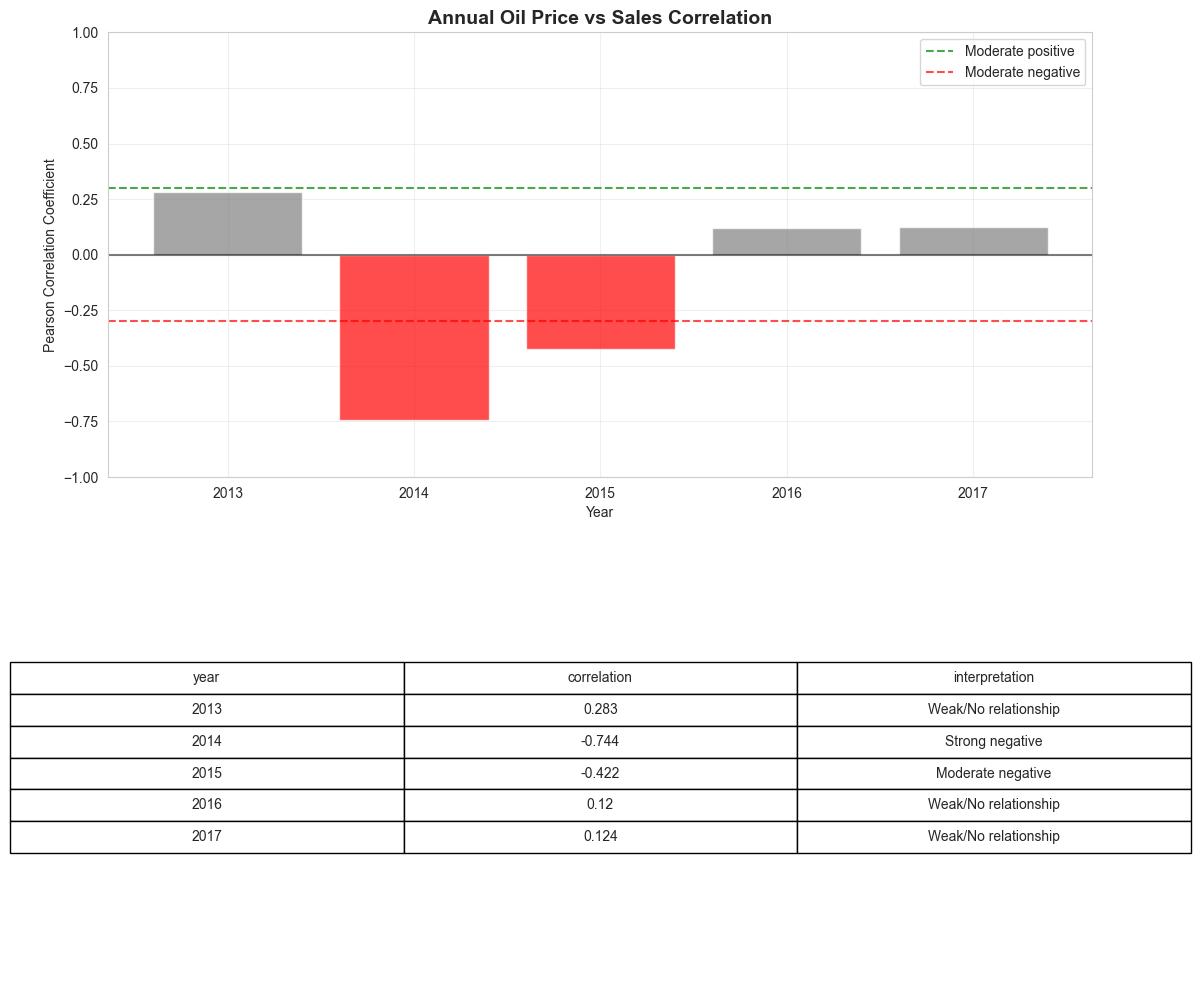

Year-by-Year Oil Price vs Sales Correlations:
 year  correlation
 2013     0.283467
 2014    -0.744430
 2015    -0.422228
 2016     0.119804
 2017     0.123696

Years with moderate+ correlation (|r| > 0.3): 2


In [55]:
# Calculate correlation for each year
annual_correlations = []

for year in sorted(df_daily_oil_sales['date'].dt.year.unique()):
    year_data = df_daily_oil_sales[df_daily_oil_sales['date'].dt.year == year]

    if len(year_data) > 10:  # Ensure sufficient data points
        corr = year_data['dcoilwtico'].corr(year_data['unit_sales'])
        annual_correlations.append({'year': year, 'correlation': corr})

annual_corr_df = pd.DataFrame(annual_correlations)

# Visualize annual correlations
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Bar plot of annual correlations
bars = ax1.bar(annual_corr_df['year'], annual_corr_df['correlation'],
               color=['red' if x < -0.3 else 'green' if x > 0.3 else 'gray'
                      for x in annual_corr_df['correlation']], alpha=0.7)

ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax1.axhline(y=0.3, color='green', linestyle='--', alpha=0.7, label='Moderate positive')
ax1.axhline(y=-0.3, color='red', linestyle='--', alpha=0.7, label='Moderate negative')

ax1.set_xlabel('Year')
ax1.set_ylabel('Pearson Correlation Coefficient')
ax1.set_title('Annual Oil Price vs Sales Correlation', fontsize=14, fontweight='bold')
ax1.set_ylim(-1, 1)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Table of results
ax2.axis('tight')
ax2.axis('off')
table_data = annual_corr_df.copy()
table_data['correlation'] = table_data['correlation'].round(3)
table_data['interpretation'] = table_data['correlation'].apply(
    lambda x: 'Strong negative' if x < -0.7 else
              'Moderate negative' if x < -0.3 else
              'Weak/No relationship' if abs(x) < 0.3 else
              'Moderate positive' if x < 0.7 else
              'Strong positive'
)

table = ax2.table(cellText=table_data.values, colLabels=table_data.columns,
                  cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

plt.tight_layout()
plt.show()

# Print summary
print("Year-by-Year Oil Price vs Sales Correlations:")
print(annual_corr_df.to_string(index=False))
print(f"\nYears with moderate+ correlation (|r| > 0.3): {len(annual_corr_df[abs(annual_corr_df['correlation']) > 0.3])}")

**Analysis**:

* The oil price crash between 2014 and 2015 seems to have affected the unit sales with a negative correlation, suggesting that consumers had more money to spend when oil got cheaper.

## Step 9 - Measure Autocorrelation

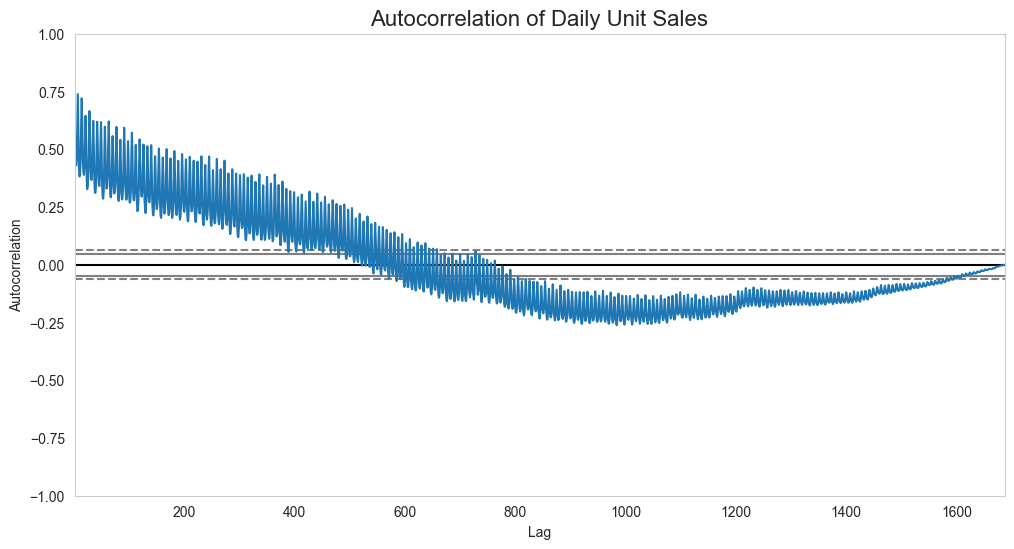

In [56]:
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

plt.figure(figsize=(12, 6))
autocorrelation_plot(sales_by_date)
plt.title('Autocorrelation of Daily Unit Sales', fontsize=16)
plt.show()

**Analysis**

* Short-term lags (left side of the plot) show a strong autocorrelation
    * This suggests that sales tend to follow a trend -> Sales today are similar to sales of the past few days
* Decay over time: The autocorrelation slowly decays
    * Even sales from months ago still have some influence on todays sales, but the correlation gets weaker over time
* Statistical Significance
    * The first 400 days are well above a p-value of 0.05 shown by the dotted line
    * This confirms that we have a strong autocorrelation for a bit more than the last year of sales!

## Step 10 - Stationarity

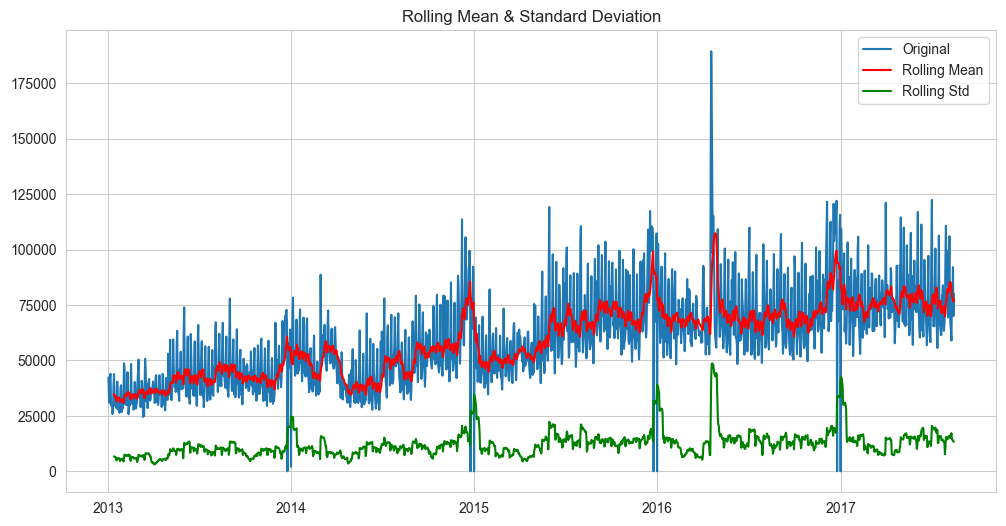

In [57]:
rolling_mean = sales_by_date.rolling(window=12).mean()
rolling_std = sales_by_date.rolling(window=12).std()

plt.figure(figsize=(12,6))
plt.plot(sales_by_date, label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='green')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

**Analysis**

* The original series and the rolling mean are increasing over time
    * The data is non-stationary
* The rolling standard deviation is more stable but still possibly increasing a tiny bit
    * To confirm this we would need a formal test

## Step 11 - Stationarity Test (ADF)

In [58]:
result = adfuller(sales_by_date)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -2.8748045528392283
p-value: 0.04835731337535463


**Analysis**

* The Augmented Dickey-Fuller test checks for a unit root, which would indicate that the series is non-stationary
* The p-value is `< 0.05`, which means that we reject the alternative hypothesis that the series is stationary